**1. Installing Required Libraries**


In [31]:
# Install required libraries
!pip install kaggle
!pip install --upgrade kagglehub
!pip install -U imbalanced-learn

**2. Import Necessary Libraries**

In [32]:
# Imports requird libraries
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix,roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

**3. Download Dataset from Kaggle**

In [33]:
# Download dataset from Kaggle
path = kagglehub.dataset_download("adityakadiwal/water-potability")
data_path = f"{path}/water_potability.csv"
df = pd.read_csv(data_path)
print(df.head())

         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  


# **Data Preprocessing**

**4. Handle Missing Data**

In [34]:
#fill null values with mean
df['ph'] = df['ph'].fillna(df['ph'].mean())
df['Sulfate'] = df['Sulfate'].fillna(df['Sulfate'].mean())
df['Trihalomethanes'] = df['Trihalomethanes'].fillna(df['Trihalomethanes'].mean())

**5. Remove Outliers**

In [35]:
#outliers
# Function for outliers determining
def outliers(df, ft):
  #calculate the quartiles
  #first quartiles
  Q1 = df[ft].quantile(0.25)
  #third quartile
  Q3 = df[ft].quantile(0.75)
  #calculate the interquartile range
  IQR = Q3 - Q1
  #lower bound and upper bound
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  #choose values that are out of range to eliminate them
  ls = df[(df[ft] < lower_bound) | (df[ft] > upper_bound)].index
  return ls

index_list = []

# Find the outliers for all features
for column in df.columns:
  index_list.extend(outliers(df, column))

#reomve duplicates
index_list = list(set(index_list))

len(index_list)

#function for removing outliers
def remove_outliers(df, index_list):
  #drop rows that contains the outliers
  df = df.drop(index_list)
  return df

#call function to remove outliers
df = remove_outliers(df, index_list)

**6. Normalize Features**

In [36]:
# Normalize features
'''scaler = StandardScaler()
X = df.drop(columns=['Potability'])
y = df['Potability']
X_scaled = scaler.fit_transform(X)'''
#normalization
for column in df.columns:
    #normalize all columns except for the target column 'POTABILITY'
    if column != 'Potability':
      df[column] = df[column]  / df[column].abs().max()

#display data after normalization
print("Normalized dataset:")
df

Normalized dataset:


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.690619,0.742662,0.465626,0.658476,0.920659,0.864791,0.446743,0.817802,0.487056,0
2,0.789941,0.812784,0.445879,0.836681,0.833867,0.641505,0.726022,0.624415,0.502309,0
3,0.811169,0.777035,0.493108,0.726948,0.891603,0.556698,0.793504,0.943312,0.760839,0
4,0.886803,0.656435,0.402644,0.590501,0.774807,0.610556,0.497466,0.300813,0.669827,0
5,0.544639,0.682575,0.643834,0.680544,0.816136,0.429811,0.361523,0.516283,0.420744,0
...,...,...,...,...,...,...,...,...,...,...
3270,0.591995,0.676579,0.585384,0.698826,0.863658,0.637338,0.519388,0.568007,0.603197,1
3272,0.761630,0.701568,0.388105,0.727131,0.833867,0.601421,0.856630,0.624191,0.459952,1
3273,0.918724,0.637083,0.742527,0.662988,0.833867,0.662099,0.475119,0.656616,0.542242,1
3274,0.500035,0.835865,0.268382,0.568560,0.833867,0.617410,0.480709,0.728466,0.773970,1


Class Distribution:
Potability
0    1671
1     995
Name: count, dtype: int64

Class Percentage:
Potability
0    62.67817
1    37.32183
Name: count, dtype: float64


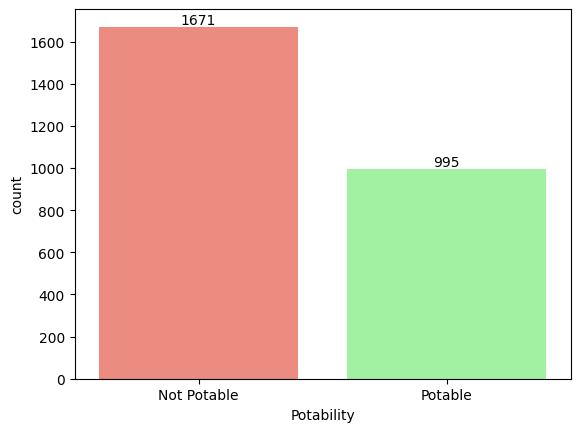

In [37]:
#check the if the data is balanced
class_distribution = df['Potability'].value_counts()

#show the number of instances in each class
print("Class Distribution:")
print(class_distribution)

#show the class instances precentages
class_percentage = class_distribution / len(df) * 100
print("\nClass Percentage:")
print(class_percentage)

# Define custom colors for each class
colors = ["salmon", "palegreen"]
# Plot the class distribution with custom colors
ax = sns.countplot(x="Potability", data=df, hue="Potability", palette=colors, saturation=0.8, legend=False)
# Customize the x-tick labels
plt.xticks(ticks=[0, 1], labels=["Not Potable", "Potable"])
# Annotate the counts on the bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge')
# Show the plot
plt.show()

**7. Split Data into Training and Testing Sets**

Class Distribution before SMOTE:
Counter({0: 1329, 1: 803})
Class Distribution in Training Set (After SMOTE): Counter({0: 1329, 1: 1329})


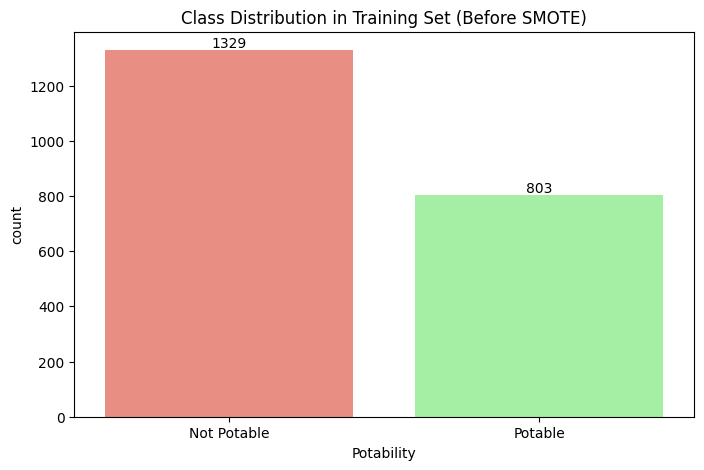

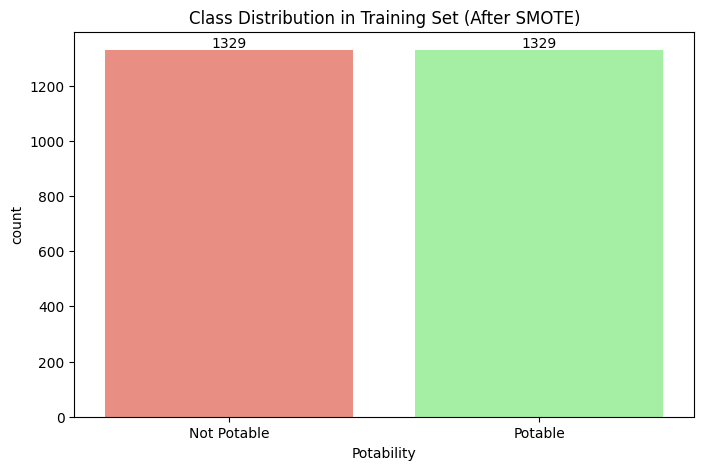

In [38]:
# Split data into training and testing sets
#define the features and the target
X = df.drop(columns=['Potability'])
y = df['Potability']

#split data to 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Class Distribution before SMOTE:")
print(Counter(y_train))
#apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

#print the class distribution in the training set after applying SMOTE
print("Class Distribution in Training Set (After SMOTE):", Counter(y_train_sm))

# Visualizations
# Define custom colors for classes
colors = ["salmon", "palegreen"]

# Training set before SMOTE
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=y_train, hue=y_train, palette=colors, legend=False)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Not Potable", "Potable"])
plt.title("Class Distribution in Training Set (Before SMOTE)")
for container in ax.containers:
    ax.bar_label(container, label_type='edge')
plt.show()

# Training set after SMOTE
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=y_train_sm, hue=y_train_sm, palette=colors, legend=False)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Not Potable", "Potable"])
plt.title("Class Distribution in Training Set (After SMOTE)")
for container in ax.containers:
    ax.bar_label(container, label_type='edge')
plt.show()

**8.Testing Model**

**1-Support Vector Machine (SVM)**

Train Accuracy: 67.308%
Test Accuracy: 66.854%


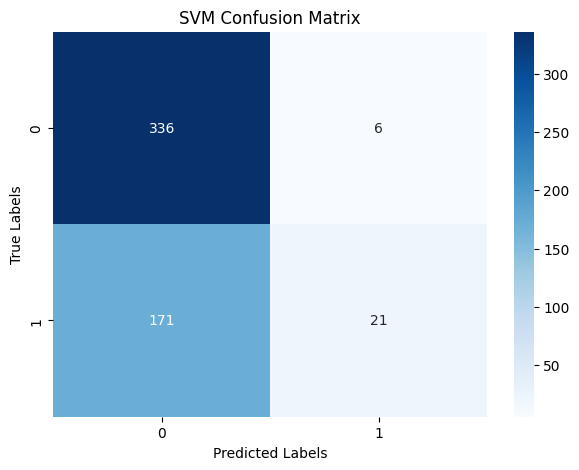

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.98      0.79       342
           1       0.78      0.11      0.19       192

    accuracy                           0.67       534
   macro avg       0.72      0.55      0.49       534
weighted avg       0.70      0.67      0.58       534



In [39]:
# Create SVM model
svm_model = SVC()

# Fit data to SVM model
svm_model.fit(X_train, y_train)

# Predict on training data
y_train_pred = svm_model.predict(X_train)

# Print the accuracy score for training
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy: %.3f%%" % (train_accuracy * 100))

# Predict on testing data
y_test_pred = svm_model.predict(X_test)

# Print the accuracy score for testing
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy: %.3f%%" % (test_accuracy * 100))

# Compute Confusion Matrix
confusion_matrix_result = confusion_matrix(y_test, y_test_pred)

# Display Confusion Matrix Using A Heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix_result, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('SVM Confusion Matrix')
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_test_pred))

**2-K-Nearest Neighbors (KNN)**

Training Accuracy: 0.83
Testing Accuracy: 0.63

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       342
           1       0.49      0.41      0.45       192

    accuracy                           0.63       534
   macro avg       0.59      0.58      0.59       534
weighted avg       0.62      0.63      0.63       534


Confusion Matrix:


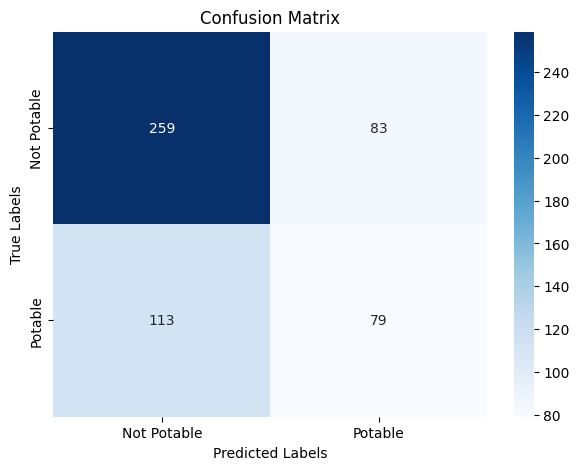

In [40]:
#training and evaluation of KNN model
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train_sm, y_train_sm)
y_train_pred = knn.predict(X_train_sm)
training_accuracy = accuracy_score(y_train_sm, y_train_pred)

#test
y_pred = knn.predict(X_test)
testing_accuracy = accuracy_score(y_test, y_pred)

#evaluate the model using performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)
f1 = f1_score(y_test, y_pred, zero_division=1)


print(f"Training Accuracy: {training_accuracy:.2f}")
print(f"Testing Accuracy: {testing_accuracy:.2f}")

#print a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

# print the confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Potable', 'Potable'], yticklabels=['Not Potable', 'Potable'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**3-Random Forest (RF)**

Train Accuracy: 100.000%
Test Accuracy: 65.356%

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.79      0.75       342
           1       0.52      0.41      0.46       192

    accuracy                           0.65       534
   macro avg       0.61      0.60      0.60       534
weighted avg       0.64      0.65      0.64       534



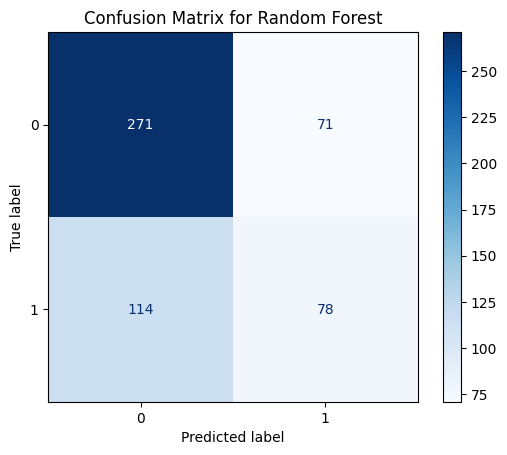

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Random Forest Classifier
random_forest = RandomForestClassifier()

# Train the Random Forest model
random_forest.fit(X_train_sm, y_train_sm)

# Predict on the test set
y_pred_rf = random_forest.predict(X_test)

# Predict on the training set
y_pred_train_rf = random_forest.predict(X_train_sm)

# Calculate training accuracy
training_accuracy_rf = accuracy_score(y_train_sm, y_pred_train_rf)

# Calculate test accuracy
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)



# Print results for training and testing
print(f"Train Accuracy: {training_accuracy_rf * 100:.3f}%")
print(f"Test Accuracy: {test_accuracy_rf * 100:.3f}%")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=random_forest.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix for Random Forest")
plt.show()

**4-Naive Bayes**

Accuracy: 0.63


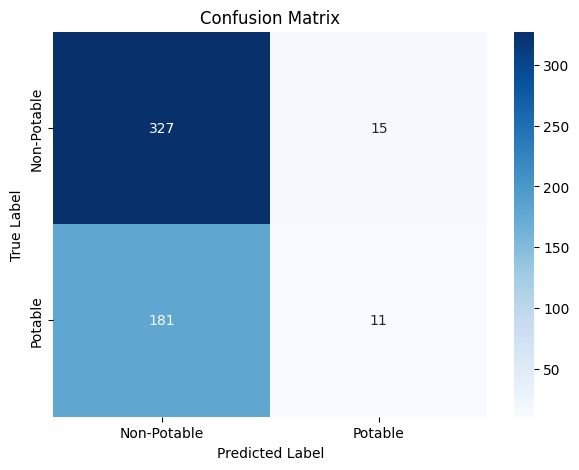

Classification Report:
               precision    recall  f1-score   support

 Non-Potable       0.64      0.96      0.77       342
     Potable       0.42      0.06      0.10       192

    accuracy                           0.63       534
   macro avg       0.53      0.51      0.44       534
weighted avg       0.56      0.63      0.53       534

Training Accuracy: 0.62
Testing Accuracy: 0.63


In [42]:
from sklearn.naive_bayes import GaussianNB

# Initialize the Naive Bayes model
nb_model = GaussianNB()

# Train the model on the training data
nb_model.fit(X_train, y_train)


# Predict on the test set
y_pred = nb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Potable", "Potable"], yticklabels=["Non-Potable", "Potable"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Generate classification report
class_report = classification_report(y_test, y_pred, target_names=["Non-Potable", "Potable"])
print("Classification Report:\n", class_report)


# Calculate accuracy on the training set
y_train_pred = nb_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Calculate accuracy on the testing set
y_test_pred = nb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_accuracy:.2f}")

**9- Show the rating accuracy**

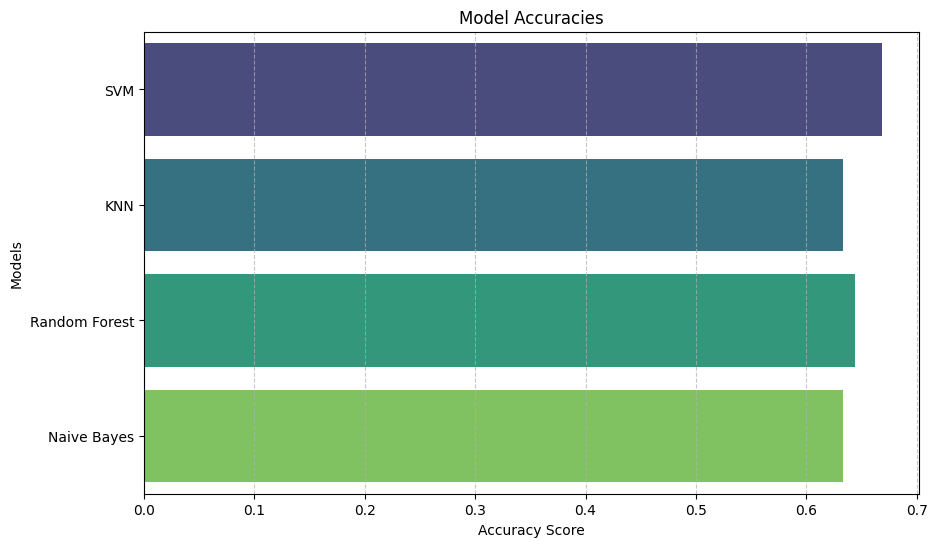

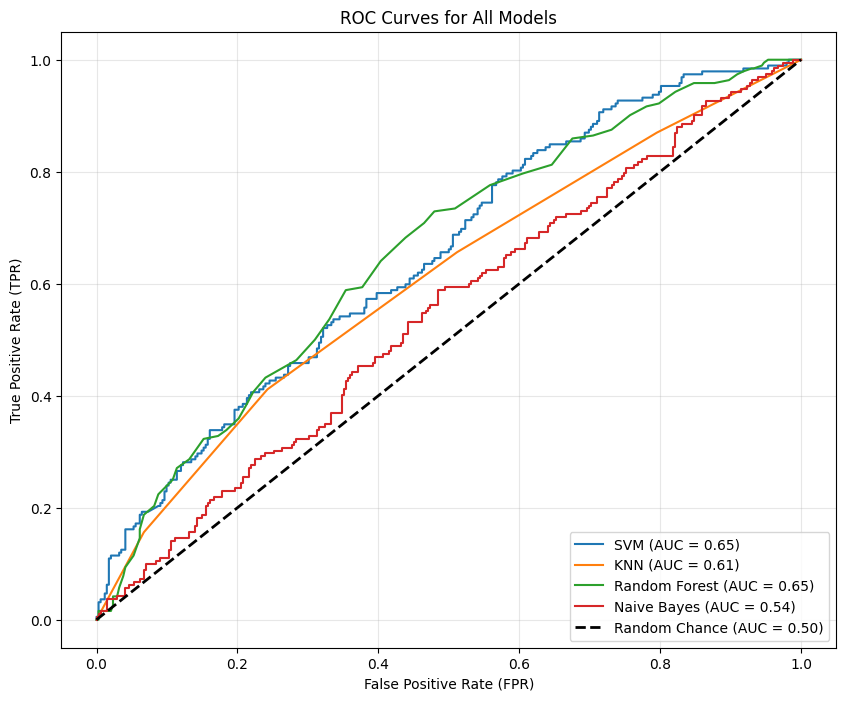

In [43]:

# Initialize dictionary to store accuracy and ROC data for each model
model_results = {
    "Model": [],
    "Accuracy_score": [],
    "FPR": [],
    "TPR": [],
    "AUC": []
}
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)


# 1. Train and evaluate the SVM model
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_model.predict_proba(X_test)[:, 1])
auc_svm = auc(fpr_svm, tpr_svm)

# Append results for SVM
model_results["Model"].append("SVM")
model_results["Accuracy_score"].append(accuracy_svm)
model_results["FPR"].append(fpr_svm)
model_results["TPR"].append(tpr_svm)
model_results["AUC"].append(auc_svm)

# 2. Train and evaluate the KNN model
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train_sm, y_train_sm)
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn.predict_proba(X_test)[:, 1])
auc_knn = auc(fpr_knn, tpr_knn)

# Append results for KNN
model_results["Model"].append("KNN")
model_results["Accuracy_score"].append(accuracy_knn)
model_results["FPR"].append(fpr_knn)
model_results["TPR"].append(tpr_knn)
model_results["AUC"].append(auc_knn)

# 3. Train and evaluate the Random Forest model
random_forest = RandomForestClassifier()
random_forest.fit(X_train_sm, y_train_sm)
y_pred_rf = random_forest.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, random_forest.predict_proba(X_test)[:, 1])
auc_rf = auc(fpr_rf, tpr_rf)

# Append results for Random Forest
model_results["Model"].append("Random Forest")
model_results["Accuracy_score"].append(accuracy_rf)
model_results["FPR"].append(fpr_rf)
model_results["TPR"].append(tpr_rf)
model_results["AUC"].append(auc_rf)

# 4. Train and evaluate the Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_model.predict_proba(X_test)[:, 1])
auc_nb = auc(fpr_nb, tpr_nb)

# Append results for Naive Bayes
model_results["Model"].append("Naive Bayes")
model_results["Accuracy_score"].append(accuracy_nb)
model_results["FPR"].append(fpr_nb)
model_results["TPR"].append(tpr_nb)
model_results["AUC"].append(auc_nb)

# Create a DataFrame for model results
results_df = pd.DataFrame(model_results)

# Plot bar chart for accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x="Accuracy_score", y="Model", data=results_df, palette="viridis", hue="Model")
plt.title("Model Accuracies")
plt.xlabel("Accuracy Score")
plt.ylabel("Models")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
for i in range(len(results_df)):
    plt.plot(
        results_df["FPR"][i],
        results_df["TPR"][i],
        label=f"{results_df['Model'][i]} (AUC = {results_df['AUC'][i]:.2f})"
    )

plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Chance (AUC = 0.50)")
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
